In [75]:
import numpy as np
import spotpy
import matplotlib.pyplot as plt

In [76]:
%matplotlib inline
import sys
import copy
import datetime as dt

import pandas as pd
import numpy as np
import matplotlib
matplotlib.style.use("ggplot")
import matplotlib.pyplot as plt

from dataloader import Dataloader 
from pcse.base import ParameterProvider

import pcse
from pcse.models import Wofost72_WLP_FD
print("This notebook was built with:")
print(f"python version: {sys.version}")
print(f"PCSE version: {pcse.__version__}")

from utils import *


This notebook was built with:
python version: 3.12.2 (tags/v3.12.2:6abddd9, Feb  6 2024, 21:26:36) [MSC v.1937 64 bit (AMD64)]
PCSE version: 5.5.6


## 1 - Paramètres de WOFOST

Dans cette partie, on va charger les paramètres qui serviront à modéliser le champ avec Wofost.

Dans cet exemple, on va essayer de simuler le champ de notre client


In [77]:
dataloader = Dataloader("data")

# ===  1 - Crop Data ===
dataloader.printCropNames()
dataloader.printCropVarietes('potato')

cropd = dataloader.getCropData('potato', 'Innovator')
# Alternativement, vous pouvez charger un fichier
# cropd = dataloader.readCropData("POT701.CAB")



# === 2 - Paramètres du sol ===
# Chargé depuis un fichier
# 1. **EC1-Coarse**
# 2. **EC2-Medium**
# 3. **EC3-Medium Fine**
# 4. **EC4-Fine**
# 5. **EC5-Very Fine**
# 6. **EC6-Fine and Permeable (Peat)**
soild = dataloader.readSoilData("ec3.soil")

# === 3 - Paramètres du site ===
# Il s'agit des paramètres du site, indépendamment de l'espèce
#        - WAV       Initial amount of water in total soil profile [cm] <- OBLIGATOIRE
#        - IFUNRN    Indicates whether non-infiltrating fraction of rain is a function of storm size (1)
#                    or not (0). Default 0
#        - NOTINF    Maximum fraction of rain not-infiltrating into the soil [0-1], default 0.
#        - SSMAX     Maximum depth of water that can be stored on the soil surface [cm]
#        - SSI       Initial depth of water stored on the surface [cm]
#        - SMLIM     Initial maximum moisture content in initial rooting depth zone [0-1], default 0.4
sited = dataloader.getSiteData(WAV=10)


# === 4 - Agromanagement ===
agrod = dataloader.readAgromanagementData('osiris_rampe_cleaned.agro')

# === 5 - Météo ===
weatherd = dataloader.getWeatherData(lat=49.5652319502033, lon=2.4757816885380457)

# On rassemble tout
parameters = ParameterProvider(cropdata=cropd, soildata=soild, sitedata=sited)

Voici la liste des espèces disponibles :
['barley', 'cassava', 'chickpea', 'cotton', 'cowpea', 'fababean', 'groundnut', 'maize', 'millet', 'mungbean', 'pigeonpea', 'potato', 'rapeseed', 'rice', 'sorghum', 'soybean', 'sugarbeet', 'sugarcane', 'sunflower', 'sweetpotato', 'tobacco', 'wheat', 'seed_onion']
Voici la liste des variétés disponibles pour : potato
['Potato_701', 'Potato_702', 'Potato_703', 'Potato_704', 'Innovator', 'Fontane', 'Markies', 'Premiere', 'Festien']


## 2 - Simulation

On peut maintenant prédire avec WoFOST

In [78]:
wofost_noDA = getWofost_WaterLimited(parameters, weatherd, agrod)
wofost_noDA.run_till_terminate()
df_wofost_noDA = pd.DataFrame(wofost_noDA.get_output())
df_wofost_noDA = df_wofost_noDA.set_index("day")
df_wofost_noDA.tail()
#plotWofostDF(df_wofost_noDA)

,DVS,LAI,TAGP,TWSO,TWLV,TWST,TWRT,TRA,RD,SM,WWLOW
day,,,,,,,,,,,
2022-10-02,1.983857,0.0,15560.833986,12050.425653,1857.161928,1653.246405,1441.836101,0.0,50.0,0.210778,22.853864
2022-10-03,1.989233,0.0,15560.833986,12050.425653,1857.161928,1653.246405,1441.836101,0.0,50.0,0.233504,23.990159
2022-10-04,1.993524,0.0,15560.833986,12050.425653,1857.161928,1653.246405,1441.836101,0.0,50.0,0.231734,23.901671
2022-10-05,1.998490,0.0,15560.833986,12050.425653,1857.161928,1653.246405,1441.836101,0.0,50.0,0.230315,23.830729
2022-10-06,2.000000,0.0,15560.833986,12050.425653,1857.161928,1653.246405,1441.836101,0.0,50.0,0.229977,23.813845


# 3 - Observations

On va réaliser des observations pour améliorer notre simulation : c'est la data assimilation.

Dans cette partie, on va utiliser les observations du client

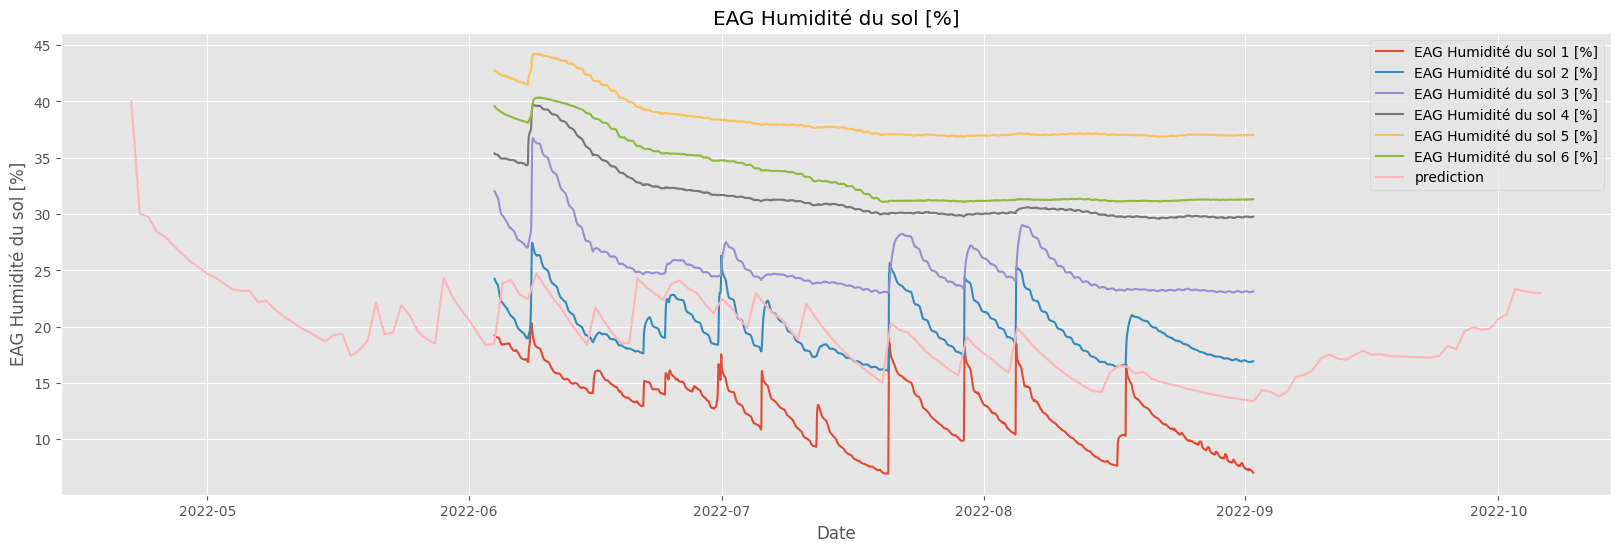

In [79]:
import matplotlib.pyplot as plt

df_obs = dataloader.readOsirisData('Sonde Rampe 1.csv')
df_obs = df_obs[df_obs['Date/heure'] < pd.Timestamp("2022-09-02")]
df_obs = df_obs[df_obs['Date/heure'] > pd.Timestamp("2022-06-04")]

plt.figure(figsize=(20, 6))

for i in range(1, 7):
    column_name = f'EAG Humidité du sol {i} [%]'
    plt.plot(df_obs['Date/heure'],df_obs[column_name], label=column_name)
    
plt.plot(df_wofost_noDA.index, df_wofost_noDA['SM']*100, label='prediction')
plt.title("EAG Humidité du sol [%]")
plt.xlabel('Date')
plt.legend()
plt.ylabel("EAG Humidité du sol [%]")
plt.grid(True)
plt.show()

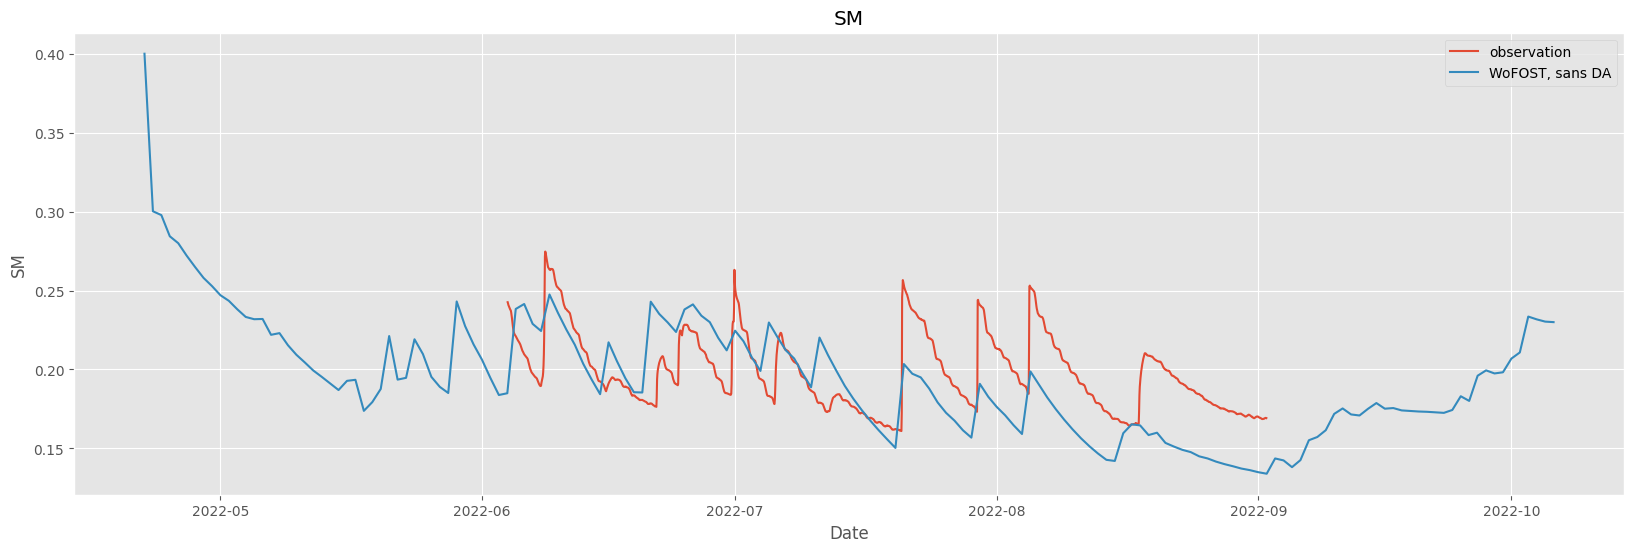

In [80]:
plt.figure(figsize=(20, 6))

plt.plot(df_obs['Date/heure'], df_obs['SM'], label = 'observation')
plt.plot(df_wofost_noDA.index, df_wofost_noDA['SM'], label='WoFOST, sans DA')
plt.title("SM")
plt.xlabel('Date')
plt.legend()
plt.ylabel("SM")
plt.grid(True)
plt.show()

Pour mesurer l'effet de la fréquence des mesures, on va échantilloner les données à notre disposition

In [81]:
NB_DAYS_DELTA = 8
dates_of_observation, observed_sm = dataloader.getOsirisSM(filename = 'Sonde Rampe 1.csv', timedelta = pd.Timedelta(NB_DAYS_DELTA, "d"), error = 0.0, begin = pd.Timestamp("2022-06-04"), end = pd.Timestamp("2022-09-02"))

observed_sm = np.array(observed_sm)
std_sm = observed_sm * 0.05 # Std. devation is estimated as 5% of observed value

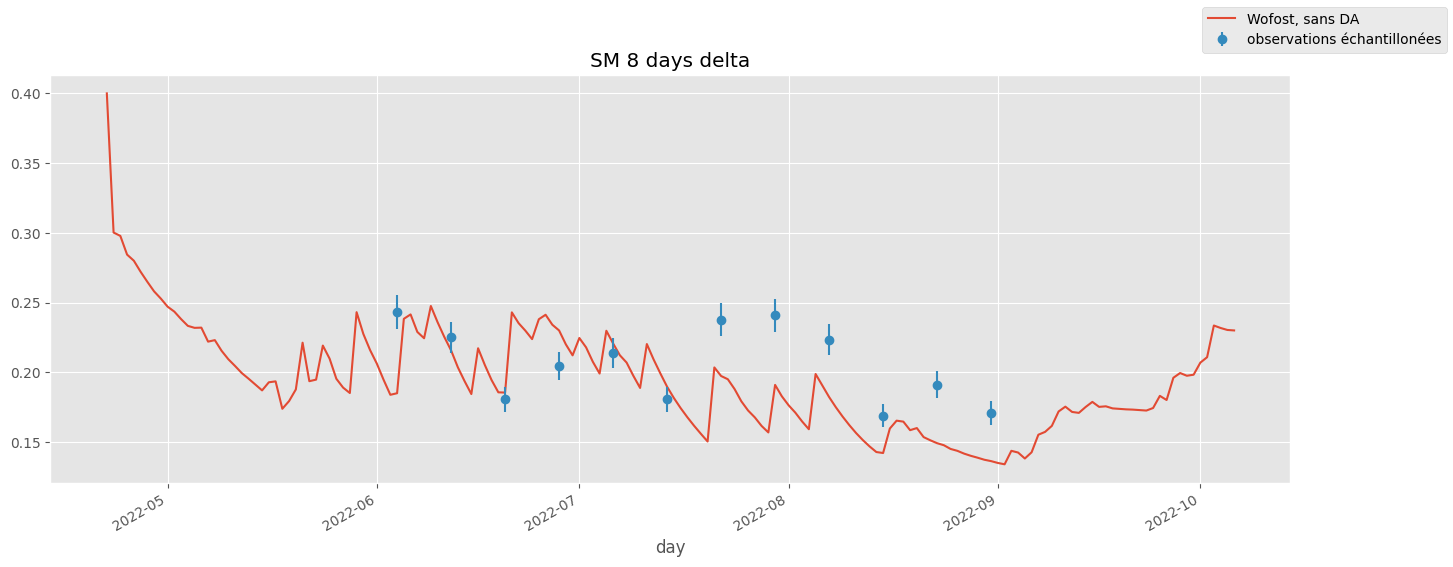

In [82]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16,6), sharex=True)
df_wofost_noDA["SM"].plot(ax=axes, label="Wofost, sans DA")
axes.errorbar(dates_of_observation, observed_sm, yerr=std_sm, fmt="o", label='observations échantillonées')
axes.set_title("SM "+str(NB_DAYS_DELTA)+" days delta")
fig.autofmt_xdate()
fig.legend()

In [83]:
observations_for_DA = [(d, {"SM": (sm, errsm)}) for d, sm, errsm in zip(dates_of_observation, observed_sm, std_sm)]

# 4 - 4DVAR

In [7]:
""""
variables_for_DA = ["LAI", "SM"]
dates_of_observation = [dt.date(2000,2,7), dt.date(2000,2,28), dt.date(2000,3,20), 
                        dt.date(2000,4,10), dt.date(2000,5,1)]
observed_lai = np.array([2.2, 3.5, 6.2, 3.3, 2.1])
std_lai = observed_lai * 0.1 # Std. devation is estimated as 10% of observed value                                                                 
observed_sm = np.array([0.285, 0.26, 0.28, 0.18, 0.17])
std_sm = observed_sm * 0.05 # Std. devation is estimated as 5% of observed value
observations_for_DA = []
# Pack them into a convenient format
observations_for_DA = [(d, {"LAI": (lai, errlai), "SM": (sm, errsm)}) for d, lai, errlai, sm, errsm in zip(dates_of_observation, observed_lai, std_lai, observed_sm, std_sm)]
"""

In [84]:
observations_for_DA

[(Timestamp('2022-06-04 00:00:00'),
  {'SM': (0.24350000000000002, 0.012175000000000002)}),
 (Timestamp('2022-06-12 00:00:00'), {'SM': (0.225, 0.011250000000000001)}),
 (Timestamp('2022-06-20 00:00:00'), {'SM': (0.1807, 0.009035)}),
 (Timestamp('2022-06-28 00:00:00'), {'SM': (0.2045, 0.010225)}),
 (Timestamp('2022-07-06 00:00:00'), {'SM': (0.2139, 0.010695000000000001)}),
 (Timestamp('2022-07-14 00:00:00'), {'SM': (0.1805, 0.009025)}),
 (Timestamp('2022-07-22 00:00:00'), {'SM': (0.2378, 0.011890000000000001)}),
 (Timestamp('2022-07-30 00:00:00'), {'SM': (0.2408, 0.01204)}),
 (Timestamp('2022-08-07 00:00:00'), {'SM': (0.2234, 0.01117)}),
 (Timestamp('2022-08-15 00:00:00'), {'SM': (0.1689, 0.008445)}),
 (Timestamp('2022-08-23 00:00:00'), {'SM': (0.191, 0.009550000000000001)}),
 (Timestamp('2022-08-31 00:00:00'), {'SM': (0.171, 0.00855)})]

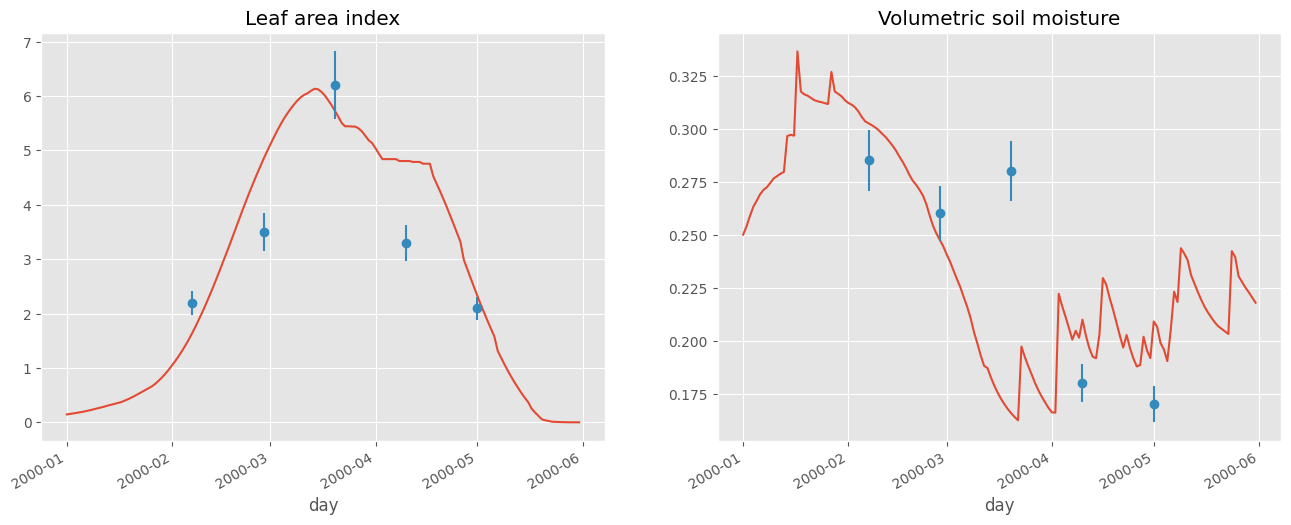

In [8]:
"""
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,6), sharex=True)
df["LAI"].plot(ax=axes[0], label="leaf area index")
axes[0].errorbar(dates_of_observation, observed_lai, yerr=std_lai, fmt="o")
df["SM"].plot(ax=axes[1], label="rootzone soil moisture")
axes[1].errorbar(dates_of_observation, observed_sm, yerr=std_sm, fmt="o")
axes[0].set_title("Leaf area index")
axes[1].set_title("Volumetric soil moisture")
fig.autofmt_xdate()
"""

In [85]:
print('== Current parameters ==')
print('TDWI', parameters['TDWI'])
print('WAV', parameters['WAV'])
print('SPAN', parameters['SPAN'])
print('SMFCF', parameters['SMFCF'])

== Current parameters ==
TDWI 75.0
WAV 10.0
SPAN 35.0
SMFCF 0.3


In [86]:
"""
Copyright 2015 by Tobias Houska
This file is part of Statistical Parameter Estimation Tool (SPOTPY).

:author: Tobias Houska

This example implements the python version of hymod into SPOTPY.
"""


import os
from spotpy.examples.hymod_python.hymod import hymod
from spotpy.objectivefunctions import rmse
from spotpy.parameter import Uniform, Normal


class spot_setup(object):

    
    param_tdwi = Normal(mean=parameters['TDWI'], stddev=10.)
    param_wav = Normal(mean=parameters['WAV'], stddev=1.0)
    param_span = Normal(mean=parameters['SPAN'], stddev=4.)
    param_smfcf = Normal(mean=parameters['SMFCF'], stddev=0.1)
    

    def __init__(self, weather, agrod, observations_for_DA):
        print('Init...')


        self.weather = weather
        self.agrod = agrod
        self.dates_of_observation = [infos[0] for infos in observations_for_DA]
        self.variables_for_DA = observations_for_DA[0][1].keys()
        self.observations_for_DA = observations_for_DA

        self.paramName_to_id = dict()
        for paramName in self.variables_for_DA:
            self.paramName_to_id[paramName] = len(self.paramName_to_id)

        self.cov_matrix = np.zeros((len(self.dates_of_observation), len(self.variables_for_DA), len(self.variables_for_DA)))
        for i in range(len(observations_for_DA)):
            infos = observations_for_DA[i]
            data = infos[1]

            for paramName, value in data.items():
                paramId = self.paramName_to_id[paramName]
                self.cov_matrix[i, paramId, paramId] = value[1] ** 2

        print("Init Done")

    def simulation(self, x):
        """
        x : paramètres (tableau)

        Cette fonction doit retourner un tableau contenant les données prédites par le modèle, pour les paramètres données
        """
        print('Simulation...')
        tdwi = x[0]
        wav = x[1]
        span = x[2]
        smfcf = x[3]

        print("tdwi", tdwi)
        print("wav", wav)
        print("span", span)
        print("smfcf", smfcf)
        

        p = copy.deepcopy(parameters)
        p.set_override("TDWI", tdwi)
        p.set_override("WAV", wav)
        p.set_override("SPAN", span)
        p.set_override("SMFCF", smfcf)

        member = Wofost72_WLP_FD(p, self.weather, self.agrod)

        try:
            member.run_till_terminate()
            df = pd.DataFrame(member.get_output())
            df['day'] = pd.to_datetime(df['day'])
            df = df.set_index("day")

            corrected_list = np.zeros(len(self.dates_of_observation) * len(self.variables_for_DA))
            
            for paramName in self.variables_for_DA:

                for i, eval_date in enumerate(self.dates_of_observation):
                    #print(">", df[df.index == eval_date], eval_date)
                    #print(">>>", df.loc[df.index == eval_date, paramName].iloc[0])

                    id = self.paramName_to_id[paramName] * len(self.dates_of_observation) + i

                    corrected_list[id] = df[df.index == eval_date][paramName].iloc[0]


            print("=== Corrected_state ===")
            print(corrected_list)

            print("Simulation done")
            return corrected_list
        except:
            print("[WARNING] SIMULATION ERROR - An error occured, abort")


            corrected_list = np.zeros(len(self.dates_of_observation) * len(self.variables_for_DA))
            
            return corrected_list

    def evaluation(self):        
        """
        Cette fonction doit donner les variables observés
        """

        observed_list = np.zeros(len(self.dates_of_observation) * len(self.variables_for_DA))
        
        for paramName in self.variables_for_DA:

            for i, eval_date in enumerate(self.dates_of_observation):
                #print(i, eval_date)

                id = self.paramName_to_id[paramName] * len(self.dates_of_observation) + i

                eval_infos = self.observations_for_DA[i][1]
                observed_list[id] = eval_infos[paramName][0]
            

        #print("Evaluation done")
        return observed_list


    def cost_function(self, estimated_list, observed_list, cov_matrix):
        J = 0
        estimated_state = np.reshape(estimated_list, (len(self.variables_for_DA), len(self.dates_of_observation)))
        observed_state = np.reshape(observed_list, (len(self.variables_for_DA), len(self.dates_of_observation)))
        for i in range(estimated_state.shape[1]):
            J += 1/2 * (observed_state[:, i]-estimated_state[:, i]).T @ \
                np.linalg.inv(
                    cov_matrix[i]) @ (observed_state[:, i]-estimated_state[:, i])
        #print('Cost done')
        return J

    def objectivefunction(self, simulation, evaluation, params=None):
        """
        Simulation : tableau contenant les données simulées
        Evaluation : tableau contenant les variables observés
        """

        #print("Simulation", simulation)
        #print("Evaluation", evaluation)

        #print('Objective...')
        
        corrected_J = self.cost_function(simulation, evaluation, self.cov_matrix)

        print('J', corrected_J)
        return corrected_J

In [61]:
spot_setup=spot_setup(weatherd, agrod, observations_for_DA)

Init...
Init Done


In [62]:
sampler=spotpy.algorithms.sceua(spot_setup, dbname='test_4dvar', dbformat='csv')

In [63]:
rep=100
sampler.sample(rep, ngs=7, kstop=3, peps=0.1, pcento=0.1)

Initializing the  Shuffled Complex Evolution (SCE-UA) algorithm  with  100  repetitions
The objective function will be minimized
Starting burn-in sampling...
Simulation...
tdwi 81.24701869795844
wav 10.19767171937425
span 31.311423060056875
smfcf 0.29742007297302364
=== Corrected_state ===
[0.18384011 0.2151602  0.18489031 0.22938191 0.21996753 0.18863896
 0.19636807 0.18996257 0.18163645 0.14668455 0.15403522 0.14321294]
Simulation done
J 54.231679832738145
Initialize database...
['csv', 'hdf5', 'ram', 'sql', 'custom', 'noData']
* Database file 'test_4dvar.csv' created.
Simulation...
tdwi 93.05674897600943
wav 10.865824094973135
span 37.137008075318846
smfcf 0.3142042721719513
=== Corrected_state ===
[0.18792578 0.21931334 0.19012633 0.23474381 0.22548162 0.19505762
 0.20222487 0.19577039 0.18727858 0.14580083 0.15309683 0.13821302]
Simulation done
J 53.01965734553808
Simulation...
tdwi 61.27400217893258
wav 11.408994427016474
span 37.774412470225016
smfcf 0.29105863569776297
=== Corr

In [87]:
p = copy.deepcopy(parameters)
p.set_override("TDWI", 72.528)
p.set_override("WAV", 10.1205)
p.set_override("SPAN", 29.4625)
p.set_override("SMFCF", 0.33968)

wofost_optimal = Wofost72_WLP_FD(p, weatherd, agrod)
wofost_optimal.run_till_terminate()
df_optimal = pd.DataFrame(wofost_optimal.get_output())
df_optimal['day'] = pd.to_datetime(df_optimal['day'])
df_optimal = df_optimal.set_index("day")

df_optimal

,DVS,LAI,TAGP,TWSO,TWLV,TWST,TWRT,TRA,RD,SM,WWLOW
day,,,,,,,,,,,
2022-04-22,-0.100000,0.072992,58.022400,0.000000,42.936576,15.085824,14.505600,0.0,10.0,0.400000,22.600500
2022-04-23,-0.096396,0.072992,58.022400,0.000000,42.936576,15.085824,14.505600,0.0,10.0,0.339880,22.474608
2022-04-24,-0.092859,0.072992,58.022400,0.000000,42.936576,15.085824,14.505600,0.0,10.0,0.337452,22.450327
2022-04-25,-0.088984,0.072992,58.022400,0.000000,42.936576,15.085824,14.505600,0.0,10.0,0.324040,22.316212
2022-04-26,-0.086318,0.072992,58.022400,0.000000,42.936576,15.085824,14.505600,0.0,10.0,0.319667,22.272475
...,...,...,...,...,...,...,...,...,...,...,...
2022-10-02,1.983857,0.000000,14519.795968,11068.809481,1842.950435,1608.036052,1414.168293,0.0,50.0,0.239894,24.133852
2022-10-03,1.989233,0.000000,14519.795968,11068.809481,1842.950435,1608.036052,1414.168293,0.0,50.0,0.262620,25.270147
2022-10-04,1.993524,0.000000,14519.795968,11068.809481,1842.950435,1608.036052,1414.168293,0.0,50.0,0.260850,25.181658


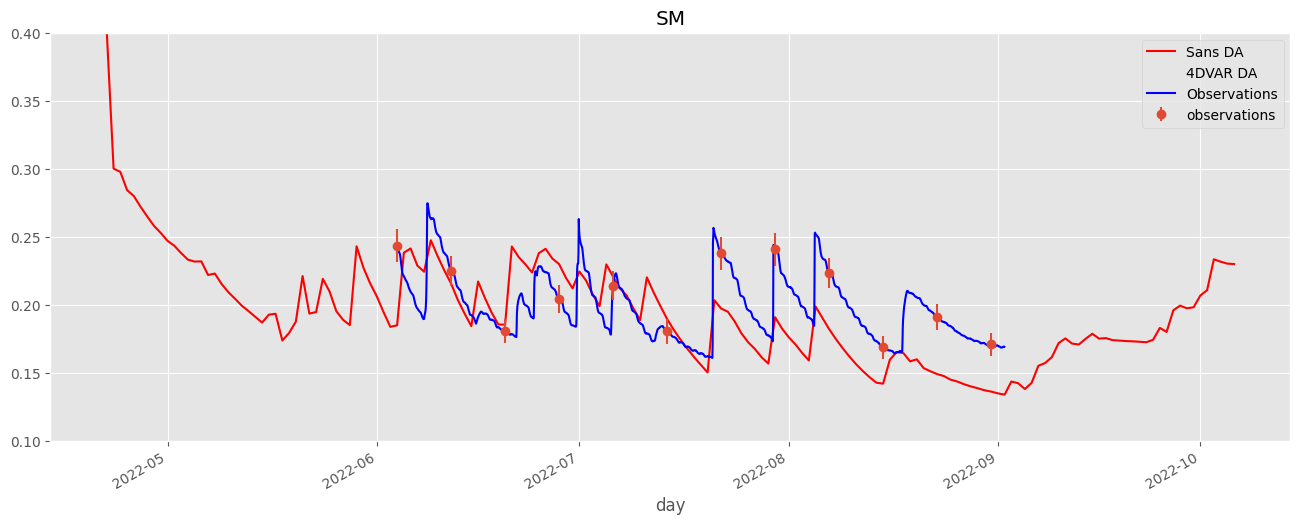

In [105]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16,6), sharex=True)
df_wofost_noDA["SM"].plot(ax=axes, label="Sans DA", alpha=1.0, color='r')
df_optimal["SM"].plot(ax=axes, label="4DVAR DA", alpha=0.0, color='g')
axes.plot(df_obs['Date/heure'], df_obs['SM'], label="Observations", color='b')
axes.errorbar(dates_of_observation, observed_sm, yerr=std_sm, fmt="o", label="observations")
axes.set_title("SM")
#axes[1].set_title("Volumetric soil moisture")
fig.autofmt_xdate()
axes.set_ylim([0.10, 0.4])
plt.legend()

In [111]:
df_optimal.tail()

,DVS,LAI,TAGP,TWSO,TWLV,TWST,TWRT,TRA,RD,SM,WWLOW
day,,,,,,,,,,,
2022-10-02,1.983857,0.0,14519.795968,11068.809481,1842.950435,1608.036052,1414.168293,0.0,50.0,0.239894,24.133852
2022-10-03,1.989233,0.0,14519.795968,11068.809481,1842.950435,1608.036052,1414.168293,0.0,50.0,0.262620,25.270147
2022-10-04,1.993524,0.0,14519.795968,11068.809481,1842.950435,1608.036052,1414.168293,0.0,50.0,0.260850,25.181658
2022-10-05,1.998490,0.0,14519.795968,11068.809481,1842.950435,1608.036052,1414.168293,0.0,50.0,0.259431,25.110716
2022-10-06,2.000000,0.0,14519.795968,11068.809481,1842.950435,1608.036052,1414.168293,0.0,50.0,0.259094,25.093833


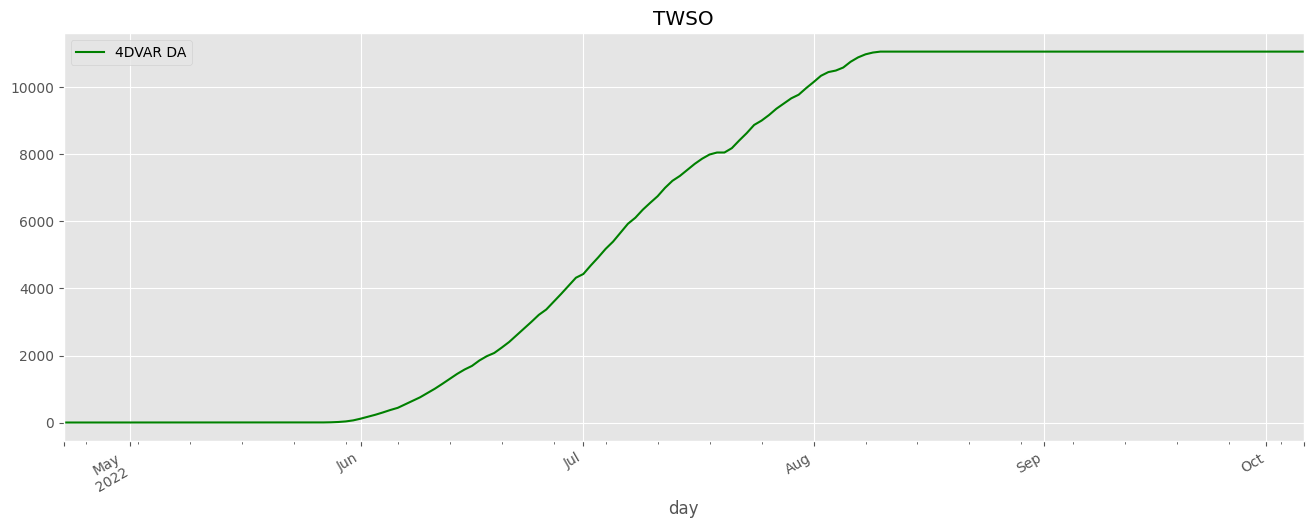

In [110]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16,6), sharex=True)
df_optimal["TWSO"].plot(ax=axes, label="4DVAR DA", alpha=1.0, color='g')
#axes.plot(df_obs['Date/heure'], df_obs['SM'], label="Observations", color='b')
axes.set_title("TWSO")
#axes[1].set_title("Volumetric soil moisture")
fig.autofmt_xdate()
#axes.set_ylim([0.10, 0.4])
plt.legend()

In [89]:
df_obs_undersample = df_obs[df_obs['Date/heure'].dt.hour == 0]
minDay = str(df_obs_undersample['Date/heure'].min())
maxDay = str(df_obs_undersample['Date/heure'].max())

SM_obs = df_obs_undersample['SM'].to_numpy()
SM_DA = df_optimal.loc[(df_optimal.index >= minDay) & (df_optimal.index <= maxDay), 'SM'].to_numpy()

from sklearn.metrics import root_mean_squared_error

root_mean_squared_error(SM_obs, SM_DA)

0.02464901174143306

In [64]:
results = spotpy.analyser.load_csv_results('test_4dvar')

AttributeError: 'Figure' object has no attribute 'set_ylim'

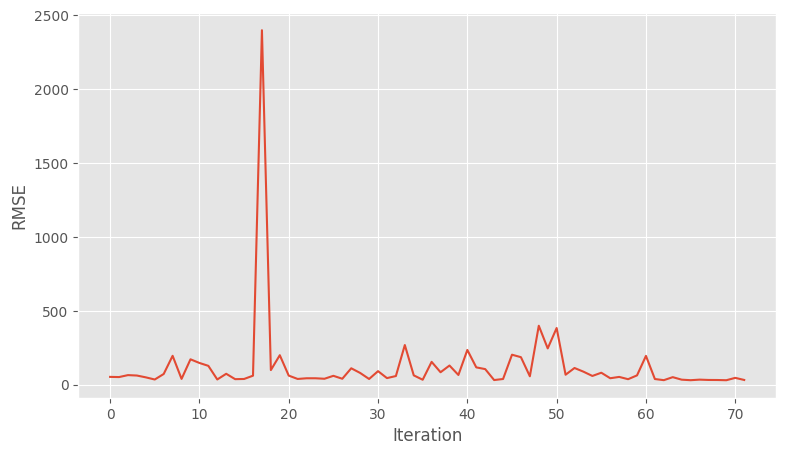

In [104]:
fig= plt.figure(1,figsize=(9,5))
plt.plot(results['like1'])
plt.ylabel('RMSE')
plt.xlabel('Iteration')
fig.savefig('SCEUA_objectivefunctiontrace.png',dpi=300)
fig.set_ylim([0, 500])

plt.show()

In [66]:
bestindex,bestobjf = spotpy.analyser.get_minlikeindex(results)

Run number 69 has the lowest objectivefunction with: 31.6665


In [67]:
best_model_run = results[bestindex]

In [68]:
fields=[word for word in best_model_run.dtype.names if word.startswith('sim')]
best_simulation = list(best_model_run[fields])

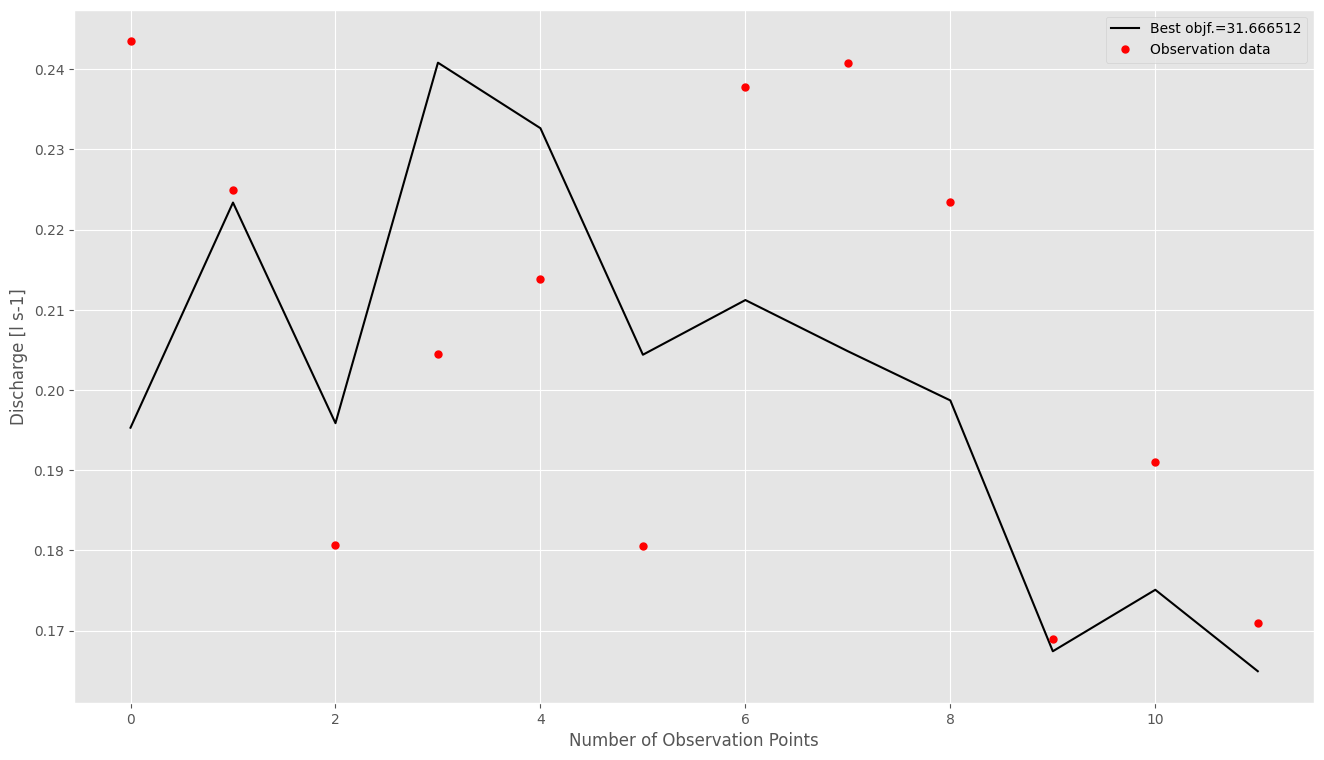

In [69]:
fig= plt.figure(figsize=(16,9))
ax = plt.subplot(1,1,1)
ax.plot(best_simulation,color='black',linestyle='solid', label='Best objf.='+str(bestobjf))
ax.plot(spot_setup.evaluation(),'r.',markersize=10, label='Observation data')
plt.xlabel('Number of Observation Points')
plt.ylabel ('Discharge [l s-1]')
plt.legend(loc='upper right')
fig.savefig('SCEUA_best_modelrun.png',dpi=300)